# Genome-scale metabolic modeling

Metabolic reactions underpin cellular function, converting nutrients into energy and cellular building blocks. Genome-scale metabolic models (GEMs) offer a holistic representation of these pathways based on an organism's genome, providing insights into its metabolic potential under various conditions. GEMs represent the collection of metabolic reactions as a [biochemical network](https://en.wikipedia.org/wiki/Metabolic_network), in which nodes represent metabolites (chemical compounds) and edges are reactions in which these metabolites participate either as substrates or as products. Additionally, GEMs include the _stoichiometry_ with which a metabolite participates in each reaction (that is, the number of molecules of each metabolite involved in the reaction).By convention, positive stoichiometric coefficients represent products and negative stoichiometric coefficients represent substrates.

> As a curiosity, biochemical networks cannot be represented by simple graphs, but rather by [hypergraphs](https://en.wikipedia.org/wiki/Hypergraph), in which edges connect more than two nodes. This is because biochemical reactions may involve multiple substrates and products. 

As in with any graph, we can represent a biochemical network by its [incidence matrix](https://en.wikipedia.org/wiki/Incidence_matrix), the stoichiometric matrix, $S$, which is a central piece of a GEM. In $S$, columns represent reactions and rows metabolites. Thus, its entries $s_{ij}$ represent the stoichiometric coefficient of metabolite $i$ in reaction $j$. Most metabolites participate in a small number of reactions, so $S$ is a sparse matrix, where most of its entries are 0.

### A toy network example

Here is a toy biochemical network with 6 metabolites $A-F$ and 5 reactions $R_{1-5}$ to help us visualize how the stoichiometric matrix is constructed. Note that in this case all stoichiometric coefficients are 1, but in actual GEMs they can be any integer (or even a fraction in the case of the biomass pseudo-reaction). Note that column vectors represent reactions, while row vectors, metabolites:

<div style="width:100%; text-align:center;">
<img src="images/toy_network.png" alt="toy network" style="width: 20%; height: auto; margin: auto">
</div>

The stoichiometric matrix $S$ is constructed by stacking the column vectors of the network, so that the first column of $S$ is the vector representing reaction $R_1$, while the first row of $S$ is the vector representing metabolite $A$, and so on. Thus, the first entry of $S$ is the stoichiometric coefficient of metabolite $A$ in reaction $R_1$ (acting as a substrate in this case):

$$
S = 
\begin{align*}
\begin{pmatrix}
-1 & 0 & 0 & -1 & 0 \\
1 & -1 & 0 & 0 & 0 \\
1 & 1 & -1 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & -1 \\
0 & 0 & 0 & 0 & 1 \\
\end{pmatrix}
\end{align*}
$$

Now, reactions transform substrates into products at a given rate, or flux. This flux is typically measured in $mmol$ of transformed product per unit time per dry weight. The interesting thing about $S$ is that it allows us to model reaction fluxes, let's name the vector of fluxes $v$. The flux vector $v$ is a vector of real numbers, where each entry $v_j$ represents the flux of reaction $j$, and it is related to the stoichiometric matrix $S$ by the following equation:

$$\frac{d}{dt}x = Sv,$$

and under [steady-state]() conditions, where the concentration of each metabolite is constant, we have:

$$Sv = 0.$$

The above is typically an underdetermined system of linear equations. Thus, instead of a single solution, we end up with a space of possible solutions, $v$, which is called the _nullspace_ of $S$. However, reaction fluxes are subject to maximum capacity and thermodynamic constraints. Ther former restricts the maximum flux of each reaction, while the latter restricts the direction of fluxes. These constraints are typically represented by a vector of lower and upper bounds, $v_{min}$ and $v_{max}$, respectively. Thus, the space of possible solutions is further restricted to the _feasible flux space_, a.k.a. the [flux cone]() $F$, which is the set of all flux vectors satisfying:

$$F = \{v: Sv = 0, v_{min} \leq v \leq v_{max}\}.$$ 


# Genome-scale models in cobrapy

`cobrapy` (COnstraint-Based Reconstruction and Analysis in PYthon) is a Python package for constraint-based modeling of metabolic networks. It provides a set of tools for the analysis of GEMs, including the ability to read and write GEMs in the [SBML]() format, and to perform [flux balance analysis]() (FBA) and [flux variability analysis]() (FVA). In this tutorial, we will use `cobrapy` to analyze a GEM of the marine diatom [_Thalassiosira pseudonana_](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0241960).

In [1]:
import numpy as np
import cobra
import matplotlib.pyplot as plt

from phycogem.reconstruction import GEM

In [2]:
gem = GEM("../data/models/iTps1432_high.xml")

# Rescale maximum flux
gem.rescale_fluxes(maximum_flux=1000)
gem

Name,iTps1432
Memory address,7f00cb700e10
Number of metabolites,2792
Number of reactions,6079
Number of genes,1432
Number of groups,93
Objective expression,4.0*DM_biomass_c - 4.0*DM_biomass_c_reverse_c49c1
Compartments,"plastid, mitochondria, cytosol, peroxisome, thylakoid membrane, extracellular"


In the summary above, we see that the model contains over 6000 biochemical reactions and more than 2700 metabolites, which are partitioned into 6 compartments: plastid, mitochondria, cytosol, peroxisome, thylakoid membrane and extracellular space. Note that _Thalassiosira_ is a phototrophic eukaryote (a microalga), thus it contains chloroplasts alongside mitochondria. A special reaction within the model is the _biomass_ reaction, a pseudo-reaction that represents the growth of the organism (more on this later), and which is set as the objective function of the model.

We can extract the stoichiometric matrix of the model as follows:

In [3]:
S = cobra.util.create_stoichiometric_matrix(gem.model)
print(f"The shape of S is {S.shape}")
print(f"S contains {100 * np.count_nonzero(S) / S.size}% non-zero elements")
print(" ")
print(S)

The shape of S is (2792, 6079)
S contains 0.1577486683217295% non-zero elements
 
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.04010769  0.
   0.        ]
 [ 0.          0.          0.         ...  1.          0.
   0.        ]
 [ 0.          0.          0.         ... -0.01311877  0.
   1.        ]]


As expected, the number of rows of the stoichiometric matrix $S$ coincides with the number of metabolites in the model, while the number of columns is the number of reactions. Additionally, only 15.8% of its entries (stoichiometric coefficients) are non-zero, which is a consequence of the sparsity of the matrix.

## Flux balance analysis

In [4]:
# Set growth medium (autotroph)
gem.set_medium("MARINE[iTPS1432]", "../data/marine_media/media_db.tsv", energy_source=("EX_photon650_e", 200))

# Optimize biomass production
sol = gem.model.optimize()
print(f"The maximum growth rate is {sol.objective_value:.2f} 1/h")

The maximum growth rate is 0.47 1/h


### Nitrogen sources

In [5]:
gem.model.reactions.get_by_id("EX_no3_e").lower_bound = 0
gem.model.reactions.get_by_id("EX_nh4_e").lower_bound = 0
gem.model.reactions.get_by_id("EX_no2_e").lower_bound = 0
gem.model.reactions.get_by_id("EX_urea_e").lower_bound = -0.1

0.23815772594480386

### Plot biomass vs maximum nitrogen uptake rate

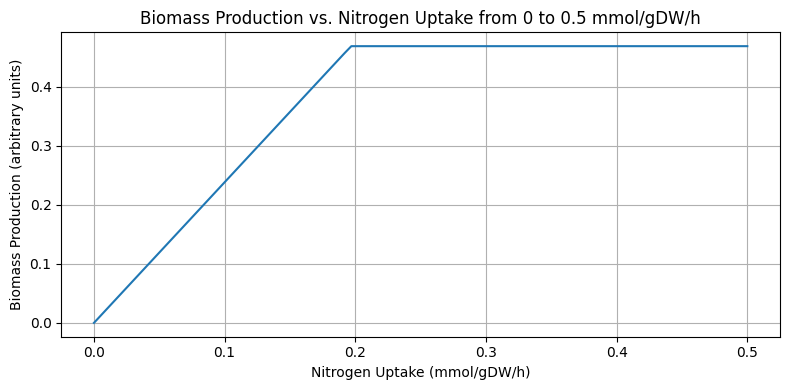

In [9]:
nitrogen_fluxes = np.linspace(0, 0.5, 100)
biomass_values = []

for no3_influx in nitrogen_fluxes:
    gem.model.reactions.get_by_id('EX_urea_e').lower_bound = -no3_influx
    solution = gem.model.optimize()
    biomass_values.append(4 * solution.fluxes['DM_biomass_c'])

plt.figure(figsize=(8, 4))
plt.plot(nitrogen_fluxes, biomass_values, color='tab:blue')
plt.xlabel('Nitrogen Uptake (mmol/gDW/h)')
plt.ylabel('Biomass Production (arbitrary units)')
plt.title('Biomass Production vs. Nitrogen Uptake from 0 to 0.5 mmol/gDW/h')
plt.grid(True)
plt.tight_layout()
plt.show()

## Analyzing the flux cone: flux variability analysis and flux sampling

In [7]:
# Run flux variability analysis and sampling
fva = gem.compute_flux_ranges()
fva

,minimum,maximum
IDP_m,0.000008,2.588737e+02
ATAM_c,0.425351,2.626732e+02
GLTS_c,0.000000,1.227813e+01
GLNA_h,0.000000,4.144894e+02
GLNA_m,0.000000,4.042971e+02
...,...,...
biomass_chitin_c,0.004523,4.523035e-03
biomass_frustule_c,0.004698,4.698370e-03
bof200_c,0.117144,1.171439e-01
biomass_EPS_c,0.000000,-1.186172e-13


In [8]:
sample = gem.sample_flux_space(n_samples=1000, n_processes=14)
sample

,IDP_m,ATAM_c,GLTS_c,GLNA_h,GLNA_m,FACOAL_181_9Z_c,ACS_c,UTAL_h,UTAL_c,ASPTA_L_h,...,biomass_mem_lipids_c,biomass_TAG_c,biomass_pigm200_h,biomass_osmo_c,biomass_vit_c,biomass_chitin_c,biomass_frustule_c,bof200_c,biomass_EPS_c,biomass_polyp_c
0,0.001956,14.273843,0.000003,87.481861,0.000254,0.002697,0.003160,0.000035,2.253404e-09,-0.003312,...,0.000082,0.000007,0.000018,0.000028,0.000002,0.000035,0.000036,0.000894,0.000116,0.000012
1,0.001968,13.814890,0.000003,34.763609,0.000494,0.002690,0.003172,0.000035,2.253376e-09,-0.003302,...,0.000083,0.000007,0.000018,0.000028,0.000002,0.000035,0.000036,0.000899,0.000116,0.000012
2,0.001915,13.802234,0.000003,34.763182,0.000475,0.002690,0.006788,0.000035,2.253383e-09,-0.004201,...,0.000083,0.000007,0.000018,0.000028,0.000002,0.000035,0.000036,0.000899,0.000116,0.000012
3,0.166451,13.951665,0.000003,34.763053,0.000679,0.002691,0.006734,0.000035,2.253379e-09,-0.004204,...,0.000083,0.000007,0.000019,0.000028,0.000002,0.000035,0.000036,0.000902,0.000110,0.000012
4,0.172315,14.115452,0.000005,36.916195,0.000652,0.003233,0.006995,0.000037,3.269657e-09,-0.004549,...,0.000088,0.000008,0.000020,0.000030,0.000002,0.000037,0.000038,0.000951,0.000115,0.000012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5.497783,15.786242,0.003036,0.429767,1.867183,0.372028,0.026161,0.000250,3.673532e-05,-0.013930,...,0.000680,0.000059,0.000152,0.000232,0.000016,0.000285,0.000296,0.007380,0.000320,0.000097
996,6.049677,16.305274,0.007579,0.082562,1.880423,0.385747,0.025552,0.000256,3.673611e-05,-0.014509,...,0.000696,0.000061,0.000155,0.000237,0.000016,0.000291,0.000303,0.007548,0.000270,0.000099
997,5.982803,16.241674,0.007577,0.269249,1.848883,0.382235,0.024134,0.000260,3.676490e-05,-0.015150,...,0.000706,0.000062,0.000157,0.000240,0.000017,0.000295,0.000307,0.007652,0.000235,0.000100
998,5.977713,16.226008,0.007580,0.191453,1.913466,0.381186,0.020384,0.000262,3.677392e-05,-0.011855,...,0.000709,0.000062,0.000158,0.000242,0.000017,0.000297,0.000309,0.007692,0.000272,0.000101
